In [54]:
# code set-up steps #

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# data sets
imdc_disaster_df = pd.read_excel('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/IDMC_disaster_corrected.xlsx')
imdc_conflict_df = pd.read_excel('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/IDMC_Internal_Displacement_Conflict-Violence_corrected.xlsx')
ocha_refugees_df = pd.read_csv('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/OCHA_refugees_corrected.csv')
ocha_data_df = pd.read_csv('ocha_weighted_avg.csv')

In [26]:
# organizing the data

# first, grouping the data that is disconnected
imdc_disaster_grouped = imdc_disaster_df.groupby(['Country / Territory', 'Year'])['Disaster Internal Displacements (Raw)'].sum()
imdc_disaster_grouped = imdc_disaster_grouped.reset_index()

# checked with print statement, looks good! 

# merging dataframes
tot_disaster_refugees = imdc_disaster_grouped.rename(columns= {'Country / Territory': 'Country'})
imdc_conflict_df = imdc_conflict_df.rename(columns= {'Name': 'Country'})
ocha_refugees_df = ocha_refugees_df.rename(columns= {'Country of origin': 'Country'})
ocha_data_df = ocha_data_df.rename(columns= {' Crisis with appeal lasting one year or more ':'Country'})

imdc_merged_df = pd.merge(tot_disaster_refugees, imdc_conflict_df, on= 'Country', how= 'outer')
refugees_all = pd.merge(imdc_merged_df, ocha_refugees_df, on= 'Country', how= 'outer')


In [37]:
# looking just at conflict numbers vs. PiN

# fixing the data flaws
refugees_all['Year_x'] = pd.to_datetime(refugees_all['Year_x'], format= '%Y', errors= 'coerce')
refugees_all['Year_y'] = pd.to_datetime(refugees_all['Year_y'], format= '%Y', errors= 'coerce')
refugees_all['Year'] = pd.to_datetime(refugees_all['Year'], format= '%Y', errors= 'coerce')

# setting up OCHA
unesa_pop_df = pd.read_excel('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/total_pop_key.xlsx')
unesa_pop_df['Year'] = pd.to_datetime(unesa_pop_df['Time'], format= '%Y', errors= 'coerce')
ocha_data_df['Year'] = pd.to_datetime(ocha_data_df['Year'], format= '%Y', errors= 'coerce')
ocha_grouped = ocha_data_df.groupby(['Country', 'Year'])[' People in Need  '].sum()
ocha_grouped = ocha_grouped.reset_index()

'''
# commented out to prevent redundancy
ocha_grouped.to_csv("ocha_cleaned.csv", index=False)
unesa_pop_df.to_csv("unesa_cleaned.csv", index=False)
'''

In [ ]:
# data creation and plotting
merged_ocha = pd.read_csv('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/merged_ocha_unesa.csv')
merged_ocha['people_in_need'].dropna()
merged_ocha['people_in_need'] = pd.to_numeric(merged_ocha['people_in_need'], errors='coerce').astype('Int64')
merged_ocha['total_population'].dropna()
merged_ocha['total_population'] = pd.to_numeric(merged_ocha['total_population'], errors='coerce').astype('Int64')

merged_ocha['PiN'] = merged_ocha['people_in_need']/merged_ocha['total_population']

# bringing in conflict data 
imdc_conflict_grouped = imdc_conflict_df.groupby(['Country', 'Year'])[['Conflict Internal Displacements (Raw)', 'Conflict Internal Displacements (Raw)']].sum().reset_index()

merged_ocha['Country'] = merged_ocha['Country'].astype(str)
imdc_conflict_grouped['Country'] = imdc_conflict_grouped['Country'].astype(str)
merged_ocha['Year'] = pd.to_numeric(merged_ocha['Year'], errors='coerce').astype('Int64')
imdc_conflict_grouped['Year'] = pd.to_numeric(imdc_conflict_grouped['Year'], errors= 'coerce').astype('Int64')

imdc_conflict_grouped

'''
merged_ocha.to_csv("merged_ocha.csv", index=False)
imdc_conflict_grouped.to_csv("imdc_grouped.csv", index=False)

'''

                            OLS Regression Results                            
Dep. Variable:         people_in_need   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     13.85
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           0.000254
Time:                        13:02:06   Log-Likelihood:                -3595.3
No. Observations:                 212   AIC:                             7195.
Df Residuals:                     210   BIC:                             7201.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

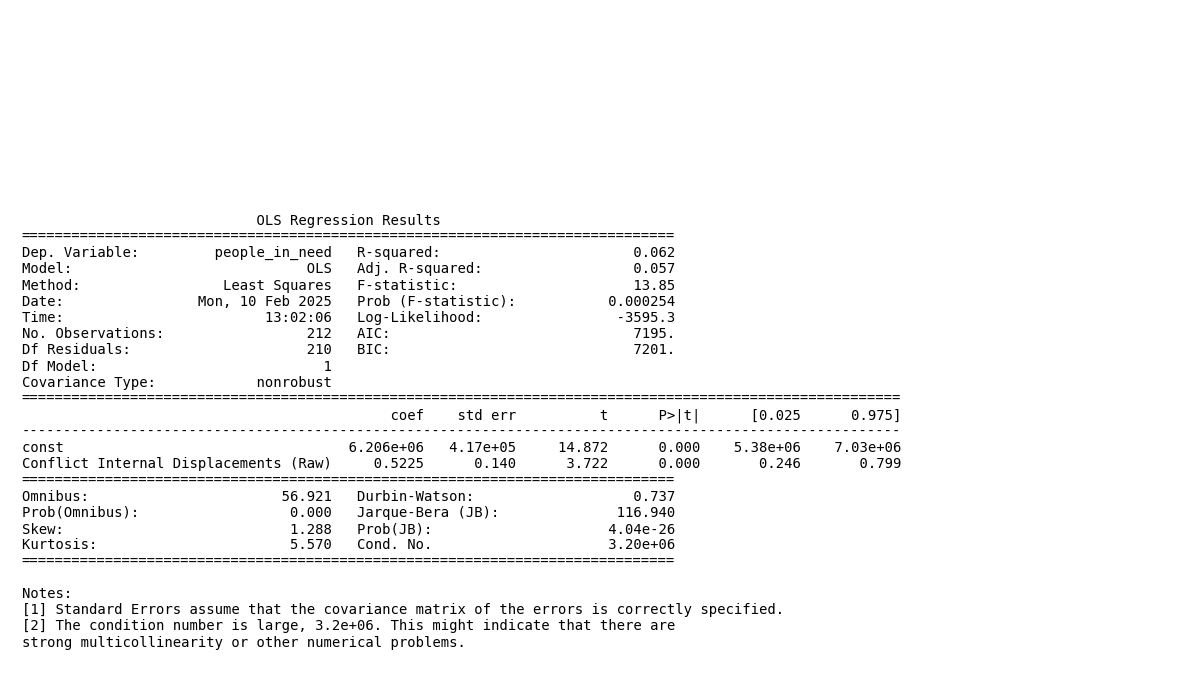

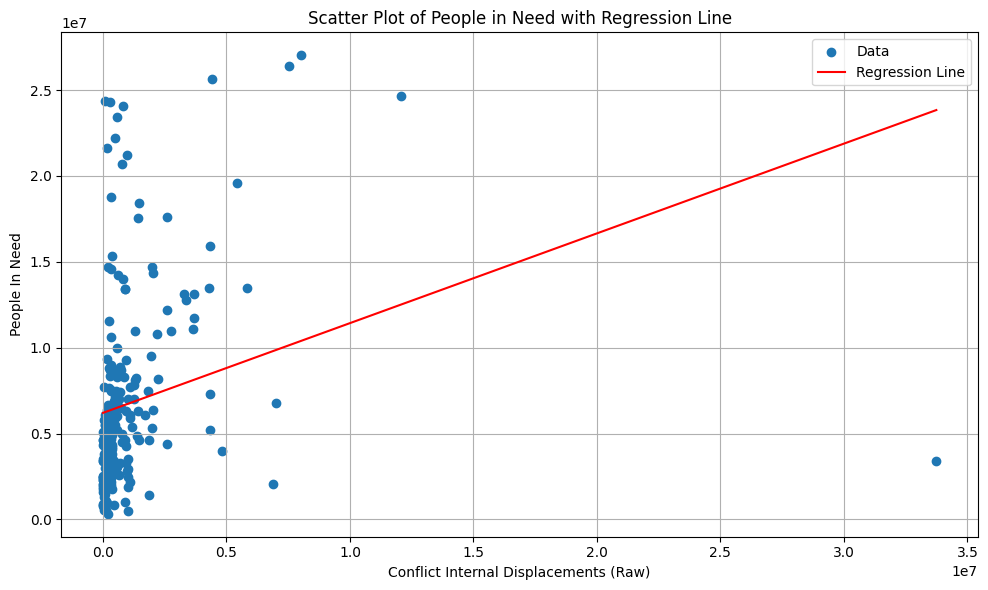

In [60]:
# re-loading the data, dropping missing rows
conflict_merged = pd.read_csv('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/final_ocha_pin.csv')
conflict_merged = conflict_merged[conflict_merged['Conflict Internal Displacements (Raw)'] != 0]

# linear regression
y = conflict_merged['people_in_need'] 
X = conflict_merged['Conflict Internal Displacements (Raw)']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig('model_summary.png')

# creating a chart!
plt.figure(figsize=(10, 6))
plt.scatter(conflict_merged['Conflict Internal Displacements (Raw)'], conflict_merged['people_in_need'], label= 'Data')
y_pred = model.predict(sm.add_constant(conflict_merged['Conflict Internal Displacements (Raw)']))
x_vals = conflict_merged['Conflict Internal Displacements (Raw)'].sort_values()
y_vals = model.predict(sm.add_constant(x_vals))
plt.plot(x_vals, y_vals, color='red', label='Regression Line')
plt.xlabel('Conflict Internal Displacements (Raw)')
plt.ylabel('People In Need')
plt.title('Scatter Plot of People in Need with Regression Line')
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.savefig('scatterplot_with_regression.png') # Save as PNG
plt.show()

                            OLS Regression Results                            
Dep. Variable:         people_in_need   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     13.85
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           0.000254
Time:                        13:11:35   Log-Likelihood:                -3595.3
No. Observations:                 212   AIC:                             7195.
Df Residuals:                     210   BIC:                             7201.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

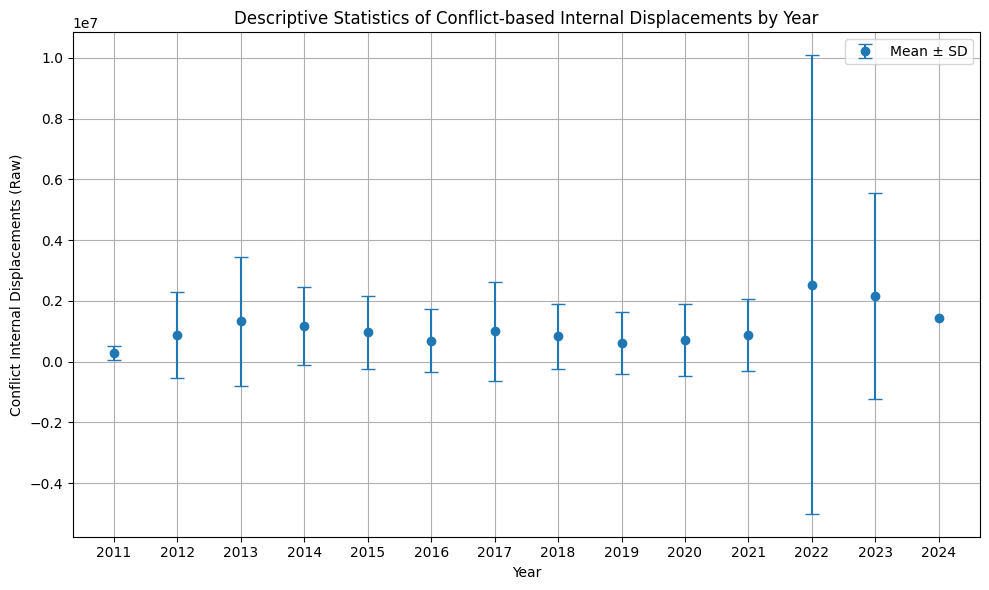


Descriptive Statistics Table:
    Year  count          mean           std        min        25%        50%  \
0   2011    8.0  2.793200e+05  2.185979e+05     2200.0   161090.0   283000.0   
1   2012   11.0  8.823915e+05  1.418411e+06      560.0   206400.0   370000.0   
2   2013   10.0  1.327220e+06  2.121356e+06     2200.0   181500.0   507000.0   
3   2014   14.0  1.171637e+06  1.293612e+06    12400.0   183500.0   673700.0   
4   2015   17.0  9.572649e+05  1.206852e+06     1482.0   141078.0   397524.0   
5   2016   19.0  6.896548e+05  1.026389e+06     1400.0    82483.0   312614.0   
6   2017   19.0  9.983557e+05  1.623454e+06     1400.0    50733.0   238754.0   
7   2018   17.0  8.254578e+05  1.079500e+06      980.0   104000.0   503928.0   
8   2019   20.0  6.161766e+05  1.027629e+06      120.0   115463.5   199745.0   
9   2020   20.0  7.019907e+05  1.179094e+06      148.0   138872.0   278601.0   
10  2021   19.0  8.675686e+05  1.182005e+06       80.0   228414.0   753326.0   
11  2022 

In [67]:
# re-loading the data, dropping missing rows
conflict_merged = pd.read_csv('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/final_ocha_pin.csv')
conflict_merged = conflict_merged[conflict_merged['Conflict Internal Displacements (Raw)'] != 0]

# linear regression
y = conflict_merged['people_in_need'] 
X = conflict_merged['Conflict Internal Displacements (Raw)']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


descriptive_stats = conflict_merged.groupby('Year')['Conflict Internal Displacements (Raw)'].describe()

# Print the descriptive statistics
print(descriptive_stats)

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Plotting the means with error bars representing standard deviation
means = descriptive_stats['mean']
errors = descriptive_stats['std']

plt.errorbar(means.index, means.values, yerr=errors.values, fmt='o', capsize=5, label='Mean ± SD') # fmt='o' adds markers

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Conflict Internal Displacements (Raw)')
plt.title('Descriptive Statistics of Conflict-based Internal Displacements by Year')
plt.legend()
plt.grid(True)
plt.xticks(means.index) # Show all years on the x-axis

plt.tight_layout()
plt.savefig('descriptive_stats_plot.png')
plt.show()



# --- Table Output (Optional) ---
# Convert the descriptive statistics to a DataFrame for better formatting
descriptive_stats_df = descriptive_stats.reset_index() #Reset index to make Year a column again
descriptive_stats_df.to_csv('descriptive_stats.csv', index=False)  # Save to CSV

#Or print as a formatted table
print("\nDescriptive Statistics Table:")
print(descriptive_stats_df)

